## Random Forest ##

*Crowd wisdom*, aggregated predictors usually performs better than single ones. The majority vote method is also know as *emsemble method*. The method works best if predictors are independent (data and method). Random forest is normally emsemble decision trees with bootstraping methods

## Voting Classifier ##


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

log_clf = LogisticRegression()
svm_clf = SVC()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
                estimators = [('lr', log_clf), ('svc', svm_clf), ('rf', rnd_clf)],
                voting = "hard"
            )

X, y = make_classification(n_samples= 2000, n_classes=2, n_features=20, 
                           n_redundant = 6, n_clusters_per_class = 2, 
                           weights = (0.95, 0.05))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9636363636363636
RandomForestClassifier 0.9606060606060606
SVC 0.9636363636363636
VotingClassifier 0.9666666666666667


## bagging and pasting ##
Using same training algorithm for each of predicor, but train in different subset of random data. This is called boostrap aggregating (aka bagging) if sampling is performed with replacement, pasting if without.

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred), bag_clf.oob_score_

(0.9666666666666667, 0.9671641791044776)

## Random Pathes and Random Subspace ##

Random patches is basically sampling features and data, subspace is sampling features only. Helps with high dimensional data. 

User hyperparameter: max_features and bootstrap_features

For subspace: use bootstrap = False, max_samples = 1.0


In [3]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=500, max_samples=100, bootstrap=True, oob_score=True)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred), rf_clf.oob_score_

(0.9651515151515152, 0.9649253731343284)

## Extra Trees ##

*Extremely Randomised* trees. The is for every node, the trees are made random by also using random threshold for each feature, rather than search best possble threshods. This will potentially reduce bias by trading variance, and making treess faster. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
ext_clf = ExtraTreesClassifier()

## Feature Importance
Random forest can also be used to measure the relative imporance of each feature, by measure how much reduction of impurity for each node using weighted average.

In [5]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10562659372070356
sepal width (cm) 0.02699371592726922
petal length (cm) 0.43641424382675187
petal width (cm) 0.43096544652527535


## Boosting
Boosting involves combine several weak learners. This is to train predictors sequentially, each trying to correct its predecessor.

Popular methods are **AdaBoost**(adaptive boosting) and **Gradient Boost**

https://www.sciencedirect.com/science/article/pii/S002200009791504X


### ADA Boosting ###
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
First base predictor is trained, relative weights of misclassified instances is then increased, the next predictor is trained using updated weights.

https://towardsdatascience.com/boosting-and-adaboost-clearly-explained-856e21152d3e

Start by assigning a weight for each sample, then increase weight for misclassified samples, find the best stump for the next one, and start again.

In [111]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

iris = load_iris()
ada_clf = AdaBoostClassifier(n_estimators=50)
ada_clf.fit(iris['data'], iris['target'])

s = cross_val_score(ada_clf, iris['data'], iris['target'], cv=6)
print(s.mean())

r = ada_clf.estimator_errors_, ada_clf.estimator_weights_, ada_clf.feature_importances_, iris['feature_names']


0.9466666666666667


## Gradient Boosting

Anothe sequencial model by fitting new predictor with residual errors made by the previous predictor. Decision tress can also be used as base predictors this is called *Gradient Tree Boosting* or *Gradient Boosted Regression Trees*(GBRT)

In [81]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=1, noise=1.1)
X.shape, y.shape

((100, 1), (100,))

In [85]:
import numpy as np
X = np.linspace(-2, 2, 100).reshape(100, 1)
noise = np.random.normal(size=100).reshape(100, 1)
y = (np.square(X) + noise).reshape(100,)

In [100]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression

from sklearn.tree import DecisionTreeRegressor

# original predictor
t1 = DecisionTreeRegressor(max_depth = 2)
t1.fit(X, y)
t1_p = t1.predict(X)

# second predictor, predicting residual error from previous predictor
y2 = y - t1_p
t2 = DecisionTreeRegressor(max_depth = 2)
t2.fit(X, y2)
t2_p = t2.predict(X)

# third predictor, predicting residual error from previous predictor
y3 =  y2 - t2_p
t3 = DecisionTreeRegressor(max_depth = 2)
t3.fit(X, y3)
t3_p = t3.predict(X)

# this combined one is used.
t_combined = t1_p + t2_p + t3_p

### SKlearn version

Note that the learning rate hyper-parameter scales the contribution of each try. If it is a low value, more trees mayhbe needed, but prediction may generalise better. This regularisation technique is called *shrinkage*

In [105]:
# Sklearn GradientBoostingRegressor offers samilar functionality of the above solution.
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators = 3, learning_rate=1)
gbrt.fit(X, y)
g = gbrt.predict(X)

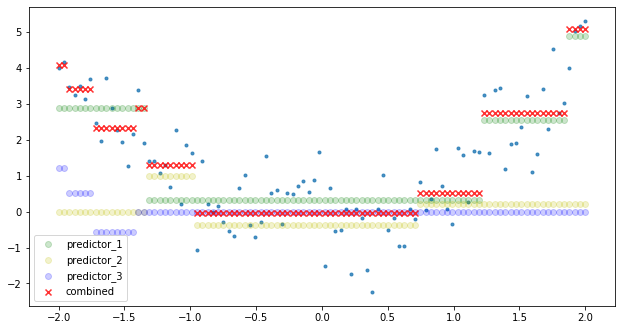

In [106]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)

ax.scatter(X, y, marker='.', alpha=0.8)
ax.scatter(X, t1_p, marker='o', alpha=0.2, c='g', label = "predictor_1")
ax.scatter(X, t2_p, marker='o', alpha=0.2, c='y', label = "predictor_2")
ax.scatter(X, t3_p, marker='o', alpha=0.2, c='b', label = "predictor_3")
ax.scatter(X, t_combined, marker='x', alpha=0.8, c='r', label = "combined")

ax.legend()

### Finding Optimal # Trees

This is done by looking at score at each stage of the ensemble, and if there are no significant improvement, stop the progression. This is called **early stop**

This can be done in sklearn by using a paramter called warm_start at True. This allows training to keep existing tress when the fit() method is called.

The class also support subsample paramter which allows only a specified training instance is used for a given tree, this will trade variance with bias.

In [110]:
from sklearn.metrics import mean_squared_error

# instantiating with warm_start
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

def finding_optimal_tree(predictor, max_estmators, X_train, y_train, X_val, y_val):
    min_val_error = float("inf")
    error_going_up = 0
    
    # loop through the number of estimator. Train with the new predictor and validate. If validate error is no longer going down (5 times), break.
    for n_estmators in range(1, max_estimators):
        predictor.n_estmators = n_estmators
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_val)
        val_error = mean_squared_error(y_val, y_pred)
        if val_error < min_val_error:
            min_val_error = val_error
            error_going_up = 0
        else:
            error_going_up += 1
            if error_going_up == 5:
                break            

## Stacking

There are another method which is also described as stacking. This is basically instead of using a voting method, training a model by blending the result of predictors as training data.